In [159]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd

In [160]:
def s2c(input_str):
    '''
    input=string
    output=corpus&word_to_id&id_to_word
    '''
    input_str = str(input_str)
    input_str = input_str.lower()
    input_str = input_str.replace('.',' .')
    
    words = input_str.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = [word_to_id[word] for word in words]
    corpus = np.array(corpus)
    
    return {'corpus':corpus, 'word_to_id':word_to_id, 'id_to_word':id_to_word}

In [161]:
def c2m(corpus,window_size=1):
    '''
    'corpus':set,including three data:corpus,word_to_id,id_to_word
    '''
    word_to_id = corpus['word_to_id']
    id_to_word = corpus['id_to_word']
    corpus = corpus['corpus']
    
    co_matrix_dims = (len(word_to_id),len(word_to_id))
    co_matrix = np.zeros(co_matrix_dims,dtype=np.int32)
    
    for word_index,word_id in enumerate(corpus):
        for applied_window_size in range(1,window_size+1):
            
            if word_index-applied_window_size >= 0:
                left_word_index = word_index-applied_window_size
                left_word_id = corpus[left_word_index]
                co_matrix[word_id,left_word_id] +=1
            
            if word_index+applied_window_size <= len(corpus)-1:
                right_word_index = word_index+applied_window_size
                right_word_id = corpus[right_word_index]
                co_matrix[word_id,right_word_id] +=1
                
    return np.array(co_matrix)

In [162]:
def wcs(x,y,eps=1e-8):
    
    '''
    computing words cos similarity
    '''
    x = x/(np.sqrt(np.sum(x**2)+eps))
    y = y/(np.sqrt(np.sum(y**2)+eps))
    
    return np.dot(x,y)

In [163]:
def tks(query,corpus,co_matrix,top_k =5):
    '''
    return a dict ,which shows the top-k words in the corpus that these words have the highest similarity with the query word
    '''
    word_to_id = corpus['word_to_id']
    id_to_word = corpus['id_to_word']
    corpus = corpus['corpus']
    
    query = str(query)
    
    #get the query word`s vector
    if query not in word_to_id.keys():
        print('f[{query}] is not in corpus,please retype')
        return
    query_id = word_to_id[query]
    query_vec = co_matrix[query_id]
    
    #creat the similarity value list about query vector in ordered word id 
    s_list = np.zeros(len(id_to_word))
    
    for i in range(len(id_to_word)):
        if query_id != i:
            s_list[i] = wcs(query_vec,co_matrix[i])
            
    #sort the similarity value list with the rule of high-low,then write in a orderedDict
    topK_similarity_dict =OrderedDict()
    
    sorted_list = np.argsort(s_list*-1)
    sorted_list = sorted_list[:top_k]
    
    for word_id in sorted_list:
        topK_similarity_dict[id_to_word[word_id]] = s_list[word_id]
    
    return topK_similarity_dict

In [164]:
def ppmi(co_matrix,verbose=False,eps=1e-8):
    '''
    pmi=log_2^{p(x,y)/p(x)*p(y)}=log_2^{C(x,y)*N/C(x)*C(y)}
    实际计算的时候为了从co_matrix直接得到ppmi，采用的是上述各个数量的近似值.并没有严格按照上面的计算方式来统计
    '''
    count=0
    
    N = np.sum(co_matrix)  #近似计算数据的单词总量
    C = np.sum(co_matrix,axis=0) #近似计算每个单词出现的次数，sum的轴表示和transpose的轴表示方法相反
    
    ppmi_matrix = np.zeros_like(co_matrix,dtype=np.float32)
    
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i,j]*N/(C[i]*C[j])+eps)
            ppmi_matrix[i,j]=max(0,pmi)
            
            if verbose:
                count += 1
                if count % (total//100+1) == 0:
                    print('%.1f%% done'% (100*cnt/total))
                    
    return ppmi_matrix

In [165]:
def svd(ppmi_matrix):
    '''
    用奇异值分解对ppmi矩阵进行降维
    '''
    U,S,V = np.linalg.svd(ppmi_matrix)
    
    return U

In [166]:
def show_word_figure(U,word_to_id):
    
    '''
    将转换之后的矩阵显示在图上，每个单词用前两个维度进行显示
    '''
    
    figure = plt.figure(figsize=(8,5))
    plt.scatter(U[:,1],U[:,0],alpha=0.5)
    for word,word_id in word_to_id.items():
        plt.annotate(word,(U[word_id,1],U[word_id,0]))
    
    figure.show()
    
    return

In [167]:
def query_and_show(querys,window_size,verbose=False,topK=5,eps=1e-8,corpus=None,input_data=None):
    if not corpus:
        corpus = s2c(input_data)

    query_result_dict = {}

    co_matrix = c2m(corpus,window_size)
    ppmi_matrix = ppmi(co_matrix,verbose,eps)

    try:
        U,S,V = randomized_svd(ppmi_matrix,n_components=min(100,co_matrix.shape[0]),n_iter=5,random_state=None)
    except:
        U=svd(ppmi_matrix)
        
    U = U[:,:min(100,co_matrix.shape[0])]
    
    for query in querys:
        topK_similarity_dict = tks(query,corpus,U,topK)
        query_result_dict[query] = topK_similarity_dict

    show_word_figure(U,corpus['word_to_id'])
    
    return query_result_dict

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6320\4009461149.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


{'hello': OrderedDict([('and', 2.1965922769595636e-07),
              ('i', 4.7283549520216184e-08),
              ('hello', 0.0),
              ('goodbye', -5.1385715238438934e-08),
              ('say', -1.1680435818561818e-07)])}

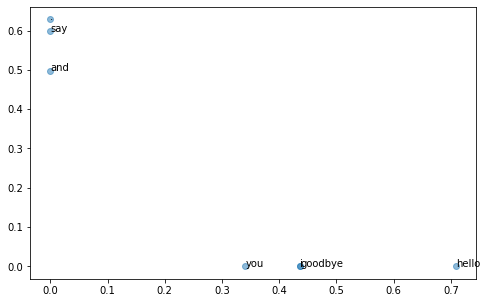

In [168]:
#测试函数
if __name__ == '__main__':

    querys = ['hello']
    input_data = 'you say goodbye and i say hello.'
    window_size = 1
    query_and_show(querys,window_size,input_data=input_data)

In [169]:
#生成训练数据
if __name__ == '__main__':
    import sys
    import os
    sys.path.append('..')
    import pickle

    dataset_dir = os.path.abspath('')
    vocab_path = dataset_dir + '\\ptb' + '\\ptb.vocab.pkl'
    save_path = dataset_dir + '\\ptb' + '\\ptb.train.npy'

    print(vocab_path)
    print(save_path)

    with open(vocab_path, 'rb') as f:
        tmp_word_to_id, tmp_id_to_word = pickle.load(f)
        tmp_corpus = np.load(save_path)

C:\Users\Administrator\Desktop\自然语言处理\ptb\ptb.vocab.pkl
C:\Users\Administrator\Desktop\自然语言处理\ptb\ptb.train.npy


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6320\713477281.py:17: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(co_matrix[i,j]*N/(C[i]*C[j])+eps)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6320\713477281.py:17: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(co_matrix[i,j]*N/(C[i]*C[j])+eps)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6320\4009461149.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


{'you': OrderedDict([('i', 0.7213600277900696),
              ('we', 0.6011824607849121),
              ('anybody', 0.5919291973114014),
              ("'ll", 0.5227175951004028),
              ('do', 0.5185359716415405)]),
 'year': OrderedDict([('quarter', 0.6491506695747375),
              ('month', 0.6311513781547546),
              ('earlier', 0.614426851272583),
              ('last', 0.5887438058853149),
              ('next', 0.5835784673690796)]),
 'car': OrderedDict([('luxury', 0.6520172953605652),
              ('auto', 0.6381800770759583),
              ('cars', 0.5400117635726929),
              ('truck', 0.4985845386981964),
              ('corsica', 0.4716678261756897)]),
 'toyota': OrderedDict([('motor', 0.727938711643219),
              ('lexus', 0.6376411318778992),
              ('motors', 0.6303754448890686),
              ('nissan', 0.607803463935852),
              ('honda', 0.5957843661308289)])}

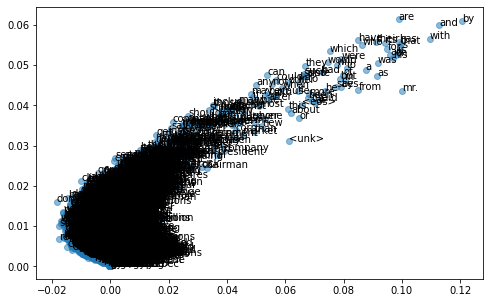

In [170]:
if __name__ == '__main__':

    querys = ['you','year','car','toyota']
    window_size = 2
    corpus={}
    corpus['corpus'] = tmp_corpus
    corpus['word_to_id'] = tmp_word_to_id
    corpus['id_to_word'] = tmp_id_to_word
    query_and_show(querys,window_size,corpus=corpus)